In [153]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import mne
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import datetime

In [162]:
torch.manual_seed(0)
np.random.seed(0)

In [115]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Limited .* annotation.* that were expanding outside the data range.",
    category=RuntimeWarning
)

In [154]:
SEQ_LEN = 128
N_SEG = 10 # Number of segments to extract from one file at once
NUM_LAYERS = 3

NUM_EPOCHS = 300
BATCH_SIZE = 64
NUM_WORKERS = 16

PATIENCE = 20 # For early stopping

device = "cuda" if torch.cuda.is_available() else "cpu"

In [117]:
plt.style.use('default')

In [118]:
def segment_data(data, n_seg):
    max_index = len(data) - SEQ_LEN

    segments = []

    for i in range(n_seg):
        start_index = np.random.randint(0, max_index)
        segment_data = data[start_index:(start_index+SEQ_LEN)]
        segments.append(segment_data.tolist())

    return torch.tensor(segments)

def generate_mask(segment, p: float, n_min: int = 1, n_max: int = 4):
    """
    Docstring for generate_mask
    
    :param segment: data for segment
    :param p: percentage of segment data to be masked
    :param n_min: minimum number of mask blocks
    :param n_max: maximum number of mask blocks
    """

    assert 0 <= p < 1, f"p must be between 0 and 1, got: {p}"

    num_mask_blocks = np.random.randint(n_min, n_max)

    max_block_length = int(len(segment) * p - num_mask_blocks)    # Make sure that each block has at least one sample

    block_lens = []

    for block_idx in range(num_mask_blocks-1):
        if max_block_length > 1:
            block_len = np.random.randint(1, max_block_length)
        else:
            block_len = 1
        block_lens.append(block_len)
        max_block_length -= block_len

    block_lens.append(max_block_length)

    mask = np.ones_like(segment)

    def get_mask_range(block_length: int):
        start_index = np.random.randint(0, len(segment)-block_length)
        end_index = block_length + start_index
        return start_index, end_index

    for block_len in block_lens:
        start_idx, end_idx = get_mask_range(block_len)
        while not np.equal(mask[start_idx:end_idx].all(), 1):
            start_idx, end_idx = get_mask_range(block_len)

        mask[start_idx:end_idx] = 0

    return torch.tensor(mask)

In [119]:
train_file_paths = glob("data/train/**/*.edf", recursive=True)
val_file_paths = glob("data/val/**/*.edf", recursive=True)

In [120]:
class EEGDataset(Dataset):
    def __init__(self, file_paths):
        super().__init__()

        # self.file_paths = file_paths

        self.data = [self._load_data(file_path) for file_path in file_paths]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # file_path = self.file_paths[idx]
        normalized_data = self.data[idx]

        segments = segment_data(normalized_data, N_SEG)

        masked_segments = []

        for segment in segments:
            mask = generate_mask(segment, p=0.1, n_min = 4, n_max = 6)
            masked_segments.append((mask*segment).tolist())

        masked_segments = torch.tensor(masked_segments)

        return masked_segments, segments
    
    def _load_data(self, file_path):
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=0)
        data, time = raw['Fc5.']
        normalized_data = (data - data.mean()) / data.std()
        return normalized_data.T

In [121]:
train_dataset = EEGDataset(train_file_paths)
val_dataset = EEGDataset(val_file_paths)

In [122]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [155]:
class EEGModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.rnn = nn.RNN(1, SEQ_LEN, NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(SEQ_LEN, 1)

    def forward(self, x):
        return self.fc(self.rnn(x)[0])

In [156]:
model = EEGModel()
model.to(device)

EEGModel(
  (rnn): RNN(1, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [157]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [158]:
class EarlyStopping:
    def __init__(self, patience=10, opt_type='minimize'):
        if opt_type == 'minimize':
            self.last_value = float('inf')
        elif opt_type == 'maximize':
            self.last_value = -float('inf')
        else:
            raise ValueError("Wrong optimization type. Should be one from ['minimize', 'maximize']")
        
        self.opt_type = opt_type
        self.patience = patience
        self.steps_no_improve = 0

    def should_stop(self, value):
        if self.opt_type == 'minimize' and value < self.last_value:
            self.last_value = value
            self.steps_no_improve = 0
        if self.opt_type == 'maximize' and value > self.last_value:
            self.last_value = value
            self.steps_no_improve = 0
        else:
            self.steps_no_improve += 1

        if self.steps_no_improve > self.patience:
            return True
        else:
            return False

In [159]:
def validate(model, val_dl, criterion):
    val_loss = 0
    for inputs, targets in tqdm(val_dl):
        inputs = inputs.flatten(0,1).to(device)
        targets = targets.flatten(0,1).to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        val_loss += loss.detach().item()

    return val_loss / len(val_dl)


def train(model, train_dl, val_dl, criterion, optimizer):
    writer = SummaryWriter(f"logs/{datetime.datetime.now()}")
    early_stopping = EarlyStopping(patience=PATIENCE)

    best_val_loss = float("inf")

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        for inputs, targets in tqdm(train_dl):
            optimizer.zero_grad()

            inputs = inputs.flatten(0,1).to(device)
            targets = targets.flatten(0,1).to(device)

            outputs = model(inputs)
            # outputs, h_n = model(inputs)
            # outputs = outputs[:, -1, :].unsqueeze(-1)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item()


        train_loss = epoch_loss / len(train_dl)
        val_loss = validate(model, val_dl, criterion)

        print(f"Epoch: {epoch} | Train loss: {train_loss} | Val loss: {val_loss}")

        writer.add_scalar("Train MSE", train_loss, global_step=epoch)
        writer.add_scalar("Val MSE", val_loss, global_step=epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best.pth")

        if early_stopping.should_stop(val_loss):
            print("\n === Early stopping stopped the training === \n")
            break
        
    torch.save(model.state_dict(), "last.pth")

In [160]:
train(model, train_dl, val_dl, criterion, optimizer)

100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


Epoch: 0 | Train loss: 0.379645587131381 | Val loss: 0.09958134219050407


100%|██████████| 4/4 [00:00<00:00, 13.39it/s]


Epoch: 1 | Train loss: 0.0818885613232851 | Val loss: 0.10246453993022442


100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


Epoch: 2 | Train loss: 0.0680210079997778 | Val loss: 0.0709275584667921


100%|██████████| 4/4 [00:00<00:00, 12.82it/s]


Epoch: 3 | Train loss: 0.0616112532094121 | Val loss: 0.07576926983892918


100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


Epoch: 4 | Train loss: 0.06106375940144062 | Val loss: 0.06744916550815105


100%|██████████| 4/4 [00:00<00:00, 13.28it/s]


Epoch: 5 | Train loss: 0.061013645678758624 | Val loss: 0.06377541553229094


100%|██████████| 4/4 [00:00<00:00, 13.19it/s]


Epoch: 6 | Train loss: 0.05970286298543215 | Val loss: 0.08341812435537577


100%|██████████| 4/4 [00:00<00:00, 13.09it/s]


Epoch: 7 | Train loss: 0.05921830218285322 | Val loss: 0.08047434408217669


100%|██████████| 4/4 [00:00<00:00, 13.22it/s]


Epoch: 8 | Train loss: 0.058237581700086596 | Val loss: 0.05957491975277662


100%|██████████| 4/4 [00:00<00:00, 13.05it/s]


Epoch: 9 | Train loss: 0.06013314388692379 | Val loss: 0.059783367440104485


100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


Epoch: 10 | Train loss: 0.058409761637449265 | Val loss: 0.05988533329218626


100%|██████████| 4/4 [00:00<00:00, 13.42it/s]


Epoch: 11 | Train loss: 0.05639874860644341 | Val loss: 0.06137062422931194


100%|██████████| 4/4 [00:00<00:00, 12.66it/s]


Epoch: 12 | Train loss: 0.05713420193642378 | Val loss: 0.07213369570672512


100%|██████████| 4/4 [00:00<00:00, 12.84it/s]


Epoch: 13 | Train loss: 0.05625436007976532 | Val loss: 0.0594691289588809


100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Epoch: 14 | Train loss: 0.05642027016729116 | Val loss: 0.056395587511360645


100%|██████████| 4/4 [00:00<00:00, 12.96it/s]


Epoch: 15 | Train loss: 0.056027546711266044 | Val loss: 0.06688403710722923


100%|██████████| 4/4 [00:00<00:00, 12.16it/s]


Epoch: 16 | Train loss: 0.055891224555671214 | Val loss: 0.062485434114933014


100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


Epoch: 17 | Train loss: 0.05639673508703709 | Val loss: 0.05292085371911526


100%|██████████| 4/4 [00:00<00:00, 12.26it/s]


Epoch: 18 | Train loss: 0.056076436676084994 | Val loss: 0.056252481415867805


100%|██████████| 4/4 [00:00<00:00, 13.24it/s]


Epoch: 19 | Train loss: 0.055044845677912235 | Val loss: 0.055078293196856976


100%|██████████| 4/4 [00:00<00:00, 12.92it/s]


Epoch: 20 | Train loss: 0.05485509093850851 | Val loss: 0.059555280953645706


100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


Epoch: 21 | Train loss: 0.05492057763040066 | Val loss: 0.05790395196527243


100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


Epoch: 22 | Train loss: 0.054472506232559684 | Val loss: 0.06190380174666643


100%|██████████| 4/4 [00:00<00:00, 13.16it/s]


Epoch: 23 | Train loss: 0.055481340549886224 | Val loss: 0.053175220265984535


100%|██████████| 4/4 [00:00<00:00, 12.51it/s]


Epoch: 24 | Train loss: 0.05322629641741514 | Val loss: 0.05391821917146444


100%|██████████| 4/4 [00:00<00:00, 13.10it/s]


Epoch: 25 | Train loss: 0.053953693993389604 | Val loss: 0.05659779626876116


100%|██████████| 4/4 [00:00<00:00, 13.36it/s]


Epoch: 26 | Train loss: 0.054342863336205485 | Val loss: 0.05247142817825079


100%|██████████| 4/4 [00:00<00:00, 13.37it/s]


Epoch: 27 | Train loss: 0.054338343627750876 | Val loss: 0.05143182910978794


100%|██████████| 4/4 [00:00<00:00, 13.21it/s]


Epoch: 28 | Train loss: 0.054189449176192284 | Val loss: 0.052746557630598545


100%|██████████| 4/4 [00:00<00:00, 12.85it/s]


Epoch: 29 | Train loss: 0.05326161775738001 | Val loss: 0.05200927797704935


100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Epoch: 30 | Train loss: 0.05388124231249094 | Val loss: 0.05088021792471409


100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Epoch: 31 | Train loss: 0.053629822470247744 | Val loss: 0.07427773531526327


100%|██████████| 4/4 [00:00<00:00, 12.97it/s]


Epoch: 32 | Train loss: 0.053731453232467176 | Val loss: 0.053712377324700356


100%|██████████| 4/4 [00:00<00:00, 13.48it/s]


Epoch: 33 | Train loss: 0.05523228719830513 | Val loss: 0.07828469201922417


100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Epoch: 34 | Train loss: 0.05366576239466667 | Val loss: 0.053312381729483604


100%|██████████| 4/4 [00:00<00:00, 13.00it/s]


Epoch: 35 | Train loss: 0.054176821187138555 | Val loss: 0.050613969564437866


100%|██████████| 4/4 [00:00<00:00, 13.47it/s]


Epoch: 36 | Train loss: 0.053202383778989316 | Val loss: 0.052900658920407295


100%|██████████| 4/4 [00:00<00:00, 13.01it/s]


Epoch: 37 | Train loss: 0.05249945502728224 | Val loss: 0.051351296715438366


100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


Epoch: 38 | Train loss: 0.05299799311906099 | Val loss: 0.06021033972501755


100%|██████████| 4/4 [00:00<00:00, 13.32it/s]


Epoch: 39 | Train loss: 0.05544714629650116 | Val loss: 0.054291894659399986


100%|██████████| 4/4 [00:00<00:00, 13.37it/s]


Epoch: 40 | Train loss: 0.054532287456095216 | Val loss: 0.05701057240366936


100%|██████████| 4/4 [00:00<00:00, 13.28it/s]


Epoch: 41 | Train loss: 0.05363674499094486 | Val loss: 0.053489687852561474


100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


Epoch: 42 | Train loss: 0.05426247101277113 | Val loss: 0.05557692237198353


100%|██████████| 4/4 [00:00<00:00, 12.41it/s]


Epoch: 43 | Train loss: 0.053091360814869405 | Val loss: 0.0535740265622735


100%|██████████| 4/4 [00:00<00:00, 12.98it/s]


Epoch: 44 | Train loss: 0.05248920656740665 | Val loss: 0.052495590411126614


100%|██████████| 4/4 [00:00<00:00, 12.73it/s]


Epoch: 45 | Train loss: 0.05280513558536768 | Val loss: 0.053550045005977154


100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


Epoch: 46 | Train loss: 0.05182226020842791 | Val loss: 0.05085731949657202


100%|██████████| 4/4 [00:00<00:00, 13.25it/s]


Epoch: 47 | Train loss: 0.053395744413137436 | Val loss: 0.0540041858330369


100%|██████████| 4/4 [00:00<00:00, 12.76it/s]


Epoch: 48 | Train loss: 0.05340261086821556 | Val loss: 0.05177275277674198


100%|██████████| 4/4 [00:00<00:00, 12.34it/s]


Epoch: 49 | Train loss: 0.05340965334326029 | Val loss: 0.05246070213615894


100%|██████████| 4/4 [00:00<00:00, 12.91it/s]


Epoch: 50 | Train loss: 0.05346595849841833 | Val loss: 0.07627707533538342


100%|██████████| 4/4 [00:00<00:00, 12.98it/s]


Epoch: 51 | Train loss: 0.05421911235898733 | Val loss: 0.0593135179951787


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Epoch: 52 | Train loss: 0.05312428008764982 | Val loss: 0.05280580464750528


100%|██████████| 4/4 [00:00<00:00, 12.14it/s]


Epoch: 53 | Train loss: 0.05286842174828053 | Val loss: 0.050079869106411934


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Epoch: 54 | Train loss: 0.05183896869421005 | Val loss: 0.05098691489547491


100%|██████████| 4/4 [00:00<00:00, 13.25it/s]


Epoch: 55 | Train loss: 0.05175672173500061 | Val loss: 0.052744380198419094


100%|██████████| 4/4 [00:00<00:00, 12.91it/s]


Epoch: 56 | Train loss: 0.05124008972197771 | Val loss: 0.05014263093471527


100%|██████████| 4/4 [00:00<00:00, 12.78it/s]


Epoch: 57 | Train loss: 0.05212870053946972 | Val loss: 0.04862003028392792


100%|██████████| 4/4 [00:00<00:00, 13.25it/s]


Epoch: 58 | Train loss: 0.05073095597326756 | Val loss: 0.046662566252052784


100%|██████████| 4/4 [00:00<00:00, 13.16it/s]


Epoch: 59 | Train loss: 0.05044444762170315 | Val loss: 0.0476192906498909


100%|██████████| 4/4 [00:00<00:00, 12.28it/s]


Epoch: 60 | Train loss: 0.04957292303442955 | Val loss: 0.04599636420607567


100%|██████████| 4/4 [00:00<00:00, 12.53it/s]


Epoch: 61 | Train loss: 0.048592598736286165 | Val loss: 0.05398198589682579


100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Epoch: 62 | Train loss: 0.048055234178900716 | Val loss: 0.04890625458210707


100%|██████████| 4/4 [00:00<00:00, 13.10it/s]


Epoch: 63 | Train loss: 0.04783064275979996 | Val loss: 0.04748347029089928


100%|██████████| 4/4 [00:00<00:00, 12.44it/s]


Epoch: 64 | Train loss: 0.04594926275312901 | Val loss: 0.04392732214182615


100%|██████████| 4/4 [00:00<00:00, 12.88it/s]


Epoch: 65 | Train loss: 0.04551185108721256 | Val loss: 0.05141987185925245


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Epoch: 66 | Train loss: 0.04543213937431574 | Val loss: 0.043089293874800205


100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch: 67 | Train loss: 0.044981980696320534 | Val loss: 0.04415329545736313


100%|██████████| 4/4 [00:00<00:00, 12.79it/s]


Epoch: 68 | Train loss: 0.04368972182273865 | Val loss: 0.041596001945436


100%|██████████| 4/4 [00:00<00:00, 13.43it/s]


Epoch: 69 | Train loss: 0.04362159818410873 | Val loss: 0.040660224854946136


100%|██████████| 4/4 [00:00<00:00, 12.72it/s]


Epoch: 70 | Train loss: 0.04110530652105808 | Val loss: 0.04083842784166336


100%|██████████| 4/4 [00:00<00:00, 13.31it/s]


Epoch: 71 | Train loss: 0.04310275614261627 | Val loss: 0.058669691905379295


100%|██████████| 4/4 [00:00<00:00, 13.19it/s]


Epoch: 72 | Train loss: 0.04052858371287584 | Val loss: 0.045481462962925434


100%|██████████| 4/4 [00:00<00:00, 12.91it/s]


Epoch: 73 | Train loss: 0.039131231047213076 | Val loss: 0.0363007434643805


100%|██████████| 4/4 [00:00<00:00, 12.74it/s]


Epoch: 74 | Train loss: 0.0385586803779006 | Val loss: 0.04284567339345813


100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Epoch: 75 | Train loss: 0.039585489220917223 | Val loss: 0.039629649836570024


100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


Epoch: 76 | Train loss: 0.03859086614102125 | Val loss: 0.03484832216054201


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Epoch: 77 | Train loss: 0.036441188864409925 | Val loss: 0.033361767418682575


100%|██████████| 4/4 [00:00<00:00, 13.45it/s]


Epoch: 78 | Train loss: 0.035923256538808346 | Val loss: 0.03474483359605074


100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


Epoch: 79 | Train loss: 0.03466914659366012 | Val loss: 0.04113527433946729


100%|██████████| 4/4 [00:00<00:00, 12.78it/s]


Epoch: 80 | Train loss: 0.035678387712687255 | Val loss: 0.03367237281054258


100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


Epoch: 81 | Train loss: 0.03341852035373449 | Val loss: 0.03921981016173959


100%|██████████| 4/4 [00:00<00:00, 13.02it/s]


Epoch: 82 | Train loss: 0.0327481041662395 | Val loss: 0.036047798581421375


100%|██████████| 4/4 [00:00<00:00, 12.38it/s]


Epoch: 83 | Train loss: 0.03340193321928382 | Val loss: 0.03602187614887953


100%|██████████| 4/4 [00:00<00:00, 12.38it/s]


Epoch: 84 | Train loss: 0.033568899426609275 | Val loss: 0.032962240278720856


100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Epoch: 85 | Train loss: 0.032188624050468205 | Val loss: 0.03442704817280173


100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


Epoch: 86 | Train loss: 0.03158660000190139 | Val loss: 0.030344038736075163


100%|██████████| 4/4 [00:00<00:00, 12.94it/s]


Epoch: 87 | Train loss: 0.031374843418598176 | Val loss: 0.027909997384995222


100%|██████████| 4/4 [00:00<00:00, 12.36it/s]


Epoch: 88 | Train loss: 0.03259647963568568 | Val loss: 0.03098089760169387


100%|██████████| 4/4 [00:00<00:00, 12.95it/s]


Epoch: 89 | Train loss: 0.0319618777371943 | Val loss: 0.028573759365826845


100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


Epoch: 90 | Train loss: 0.031101953983306885 | Val loss: 0.03706329967826605


100%|██████████| 4/4 [00:00<00:00, 12.90it/s]


Epoch: 91 | Train loss: 0.030395606718957423 | Val loss: 0.040817498695105314


100%|██████████| 4/4 [00:00<00:00, 12.88it/s]


Epoch: 92 | Train loss: 0.030329185351729394 | Val loss: 0.026954168919473886


100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


Epoch: 93 | Train loss: 0.029742702841758728 | Val loss: 0.02763673383742571


100%|██████████| 4/4 [00:00<00:00, 13.53it/s]


Epoch: 94 | Train loss: 0.02963886559009552 | Val loss: 0.028570455964654684


100%|██████████| 4/4 [00:00<00:00, 12.97it/s]


Epoch: 95 | Train loss: 0.02987335780635476 | Val loss: 0.027453317306935787


100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


Epoch: 96 | Train loss: 0.029604592453688384 | Val loss: 0.02905733371153474


100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


Epoch: 97 | Train loss: 0.029670658335089684 | Val loss: 0.026835165917873383


100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Epoch: 98 | Train loss: 0.029864860232919455 | Val loss: 0.032950971741229296


100%|██████████| 4/4 [00:00<00:00, 13.33it/s]


Epoch: 99 | Train loss: 0.02949909083545208 | Val loss: 0.028055398259311914


100%|██████████| 4/4 [00:00<00:00, 13.26it/s]


Epoch: 100 | Train loss: 0.029111861903220414 | Val loss: 0.029157825745642185


100%|██████████| 4/4 [00:00<00:00, 12.64it/s]


Epoch: 101 | Train loss: 0.0293008079752326 | Val loss: 0.027591857593506575


100%|██████████| 4/4 [00:00<00:00, 13.04it/s]


Epoch: 102 | Train loss: 0.02842366537079215 | Val loss: 0.03947917092591524


100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


Epoch: 103 | Train loss: 0.028573385812342166 | Val loss: 0.026174851693212986


100%|██████████| 4/4 [00:00<00:00, 13.43it/s]


Epoch: 104 | Train loss: 0.02854789076372981 | Val loss: 0.02693702606484294


100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Epoch: 105 | Train loss: 0.027446892578154802 | Val loss: 0.025544942822307348


100%|██████████| 4/4 [00:00<00:00, 12.64it/s]


Epoch: 106 | Train loss: 0.026686561945825815 | Val loss: 0.03216756787151098


100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


Epoch: 107 | Train loss: 0.0282239705324173 | Val loss: 0.024515869561582804


100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


Epoch: 108 | Train loss: 0.02746856790035963 | Val loss: 0.025188652332872152


100%|██████████| 4/4 [00:00<00:00, 12.58it/s]


Epoch: 109 | Train loss: 0.028283513989299534 | Val loss: 0.027957667130976915


100%|██████████| 4/4 [00:00<00:00, 13.29it/s]


Epoch: 110 | Train loss: 0.028206256125122307 | Val loss: 0.0270926496013999


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Epoch: 111 | Train loss: 0.026775380689650775 | Val loss: 0.023901668842881918


100%|██████████| 4/4 [00:00<00:00, 13.24it/s]


Epoch: 112 | Train loss: 0.026635192148387433 | Val loss: 0.02428180305287242


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]


Epoch: 113 | Train loss: 0.027113780099898576 | Val loss: 0.025304135400801897


100%|██████████| 4/4 [00:00<00:00, 12.54it/s]


Epoch: 114 | Train loss: 0.02591489190235734 | Val loss: 0.024223737884312868


100%|██████████| 4/4 [00:00<00:00, 12.75it/s]


Epoch: 115 | Train loss: 0.026722676027566193 | Val loss: 0.02395192440599203


100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


Epoch: 116 | Train loss: 0.026887103728950024 | Val loss: 0.023829894606024027


100%|██████████| 4/4 [00:00<00:00, 13.20it/s]


Epoch: 117 | Train loss: 0.026538163982331754 | Val loss: 0.02606250811368227


100%|██████████| 4/4 [00:00<00:00, 12.99it/s]


Epoch: 118 | Train loss: 0.026521019451320172 | Val loss: 0.030802168417721987


100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Epoch: 119 | Train loss: 0.026075894571840764 | Val loss: 0.022962535033002496


100%|██████████| 4/4 [00:00<00:00, 13.33it/s]


Epoch: 120 | Train loss: 0.025832332018762828 | Val loss: 0.032767318887636065


100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Epoch: 121 | Train loss: 0.02593076676130295 | Val loss: 0.025353241246193647


100%|██████████| 4/4 [00:00<00:00, 13.09it/s]


Epoch: 122 | Train loss: 0.025628904160112143 | Val loss: 0.02673283452168107


100%|██████████| 4/4 [00:00<00:00, 13.24it/s]


Epoch: 123 | Train loss: 0.025634133163839577 | Val loss: 0.02440887037664652


100%|██████████| 4/4 [00:00<00:00, 13.28it/s]


Epoch: 124 | Train loss: 0.025546191446483135 | Val loss: 0.023512826999649405


100%|██████████| 4/4 [00:00<00:00, 13.37it/s]


Epoch: 125 | Train loss: 0.026185460109263658 | Val loss: 0.024524095002561808


100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Epoch: 126 | Train loss: 0.025141456350684165 | Val loss: 0.023162685334682465


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Epoch: 127 | Train loss: 0.025811466760933398 | Val loss: 0.04427944868803024


100%|██████████| 4/4 [00:00<00:00, 12.51it/s]


Epoch: 128 | Train loss: 0.025924268737435342 | Val loss: 0.042852973099797964


100%|██████████| 4/4 [00:00<00:00, 13.43it/s]


Epoch: 129 | Train loss: 0.025171456299722193 | Val loss: 0.02294920291751623


100%|██████████| 4/4 [00:00<00:00, 13.00it/s]


Epoch: 130 | Train loss: 0.025633522868156434 | Val loss: 0.022879552096128464


100%|██████████| 4/4 [00:00<00:00, 13.62it/s]


Epoch: 131 | Train loss: 0.0245591975748539 | Val loss: 0.02273820829577744


100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


Epoch: 132 | Train loss: 0.02526874765753746 | Val loss: 0.023901038570329547


100%|██████████| 4/4 [00:00<00:00, 13.47it/s]


Epoch: 133 | Train loss: 0.025984946824610233 | Val loss: 0.03995334589853883


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Epoch: 134 | Train loss: 0.02639584569260478 | Val loss: 0.024526191875338554


100%|██████████| 4/4 [00:00<00:00, 12.54it/s]


Epoch: 135 | Train loss: 0.024829563219100237 | Val loss: 0.021993684116750956


100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


Epoch: 136 | Train loss: 0.02438718806952238 | Val loss: 0.028154977597296238


100%|██████████| 4/4 [00:00<00:00, 13.42it/s]


Epoch: 137 | Train loss: 0.024458122532814743 | Val loss: 0.02492685685865581


100%|██████████| 4/4 [00:00<00:00, 13.29it/s]


Epoch: 138 | Train loss: 0.024668424297124146 | Val loss: 0.024225874803960323


100%|██████████| 4/4 [00:00<00:00, 12.95it/s]


Epoch: 139 | Train loss: 0.023898700810968877 | Val loss: 0.04290898144245148


100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


Epoch: 140 | Train loss: 0.024919257685542106 | Val loss: 0.025062572676688433


100%|██████████| 4/4 [00:00<00:00, 13.08it/s]


Epoch: 141 | Train loss: 0.025033154245465993 | Val loss: 0.02219577762298286


100%|██████████| 4/4 [00:00<00:00, 13.13it/s]


Epoch: 142 | Train loss: 0.024341613799333573 | Val loss: 0.027114505413919687


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Epoch: 143 | Train loss: 0.024098223075270653 | Val loss: 0.023276215884834528


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Epoch: 144 | Train loss: 0.02437292616814375 | Val loss: 0.022430105367675424


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]


Epoch: 145 | Train loss: 0.02501726532354951 | Val loss: 0.027135225478559732


100%|██████████| 4/4 [00:00<00:00, 12.75it/s]


Epoch: 146 | Train loss: 0.02372933840379119 | Val loss: 0.022612068569287658


100%|██████████| 4/4 [00:00<00:00, 12.90it/s]


Epoch: 147 | Train loss: 0.024345817789435387 | Val loss: 0.022082386072725058


100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


Epoch: 148 | Train loss: 0.023885534983128308 | Val loss: 0.022495748940855265


100%|██████████| 4/4 [00:00<00:00, 13.05it/s]


Epoch: 149 | Train loss: 0.030057648476213217 | Val loss: 0.030086715705692768


100%|██████████| 4/4 [00:00<00:00, 12.94it/s]


Epoch: 150 | Train loss: 0.02693568468093872 | Val loss: 0.027012141654267907


100%|██████████| 4/4 [00:00<00:00, 13.10it/s]


Epoch: 151 | Train loss: 0.024191994220018387 | Val loss: 0.022565629798918962


100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Epoch: 152 | Train loss: 0.023961661942303182 | Val loss: 0.026087550213560462


100%|██████████| 4/4 [00:00<00:00, 12.95it/s]


Epoch: 153 | Train loss: 0.024238080997020007 | Val loss: 0.046277355402708054


100%|██████████| 4/4 [00:00<00:00, 12.79it/s]


Epoch: 154 | Train loss: 0.024006006214767693 | Val loss: 0.022770187817513943


100%|██████████| 4/4 [00:00<00:00, 12.48it/s]

Epoch: 155 | Train loss: 0.024093898851424454 | Val loss: 0.029258848633617163

 === Early stopping stopped the training === 



In [172]:
best_state_dict = torch.load("best.pth", weights_only=True, map_location=device)
model.load_state_dict(best_state_dict)
model.eval()

EEGModel(
  (rnn): RNN(1, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [177]:
example_input, example_target = next(iter(val_dl))
example_input = example_input[0]
example_target = example_target[0]

In [178]:
outputs = model(example_input.to(device))

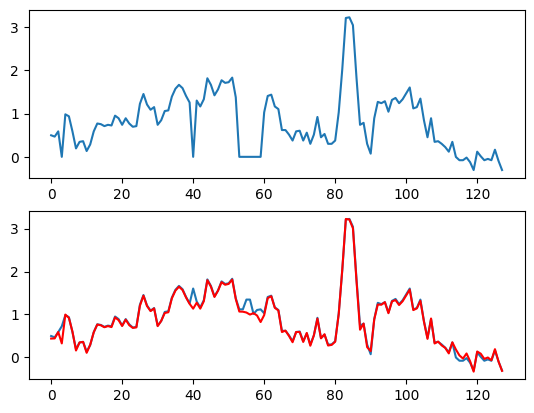

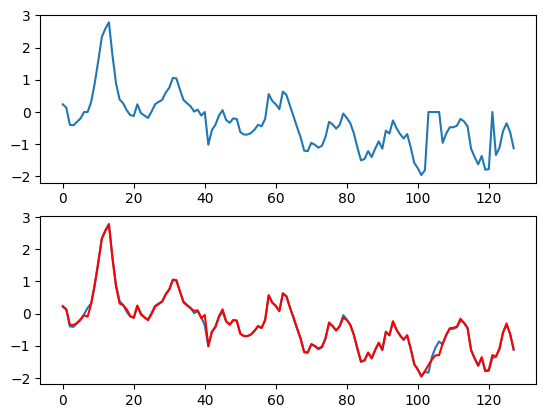

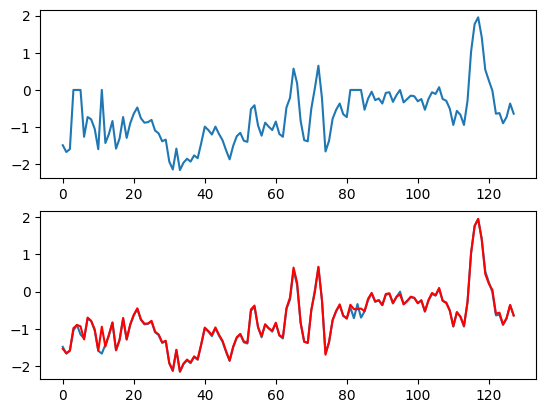

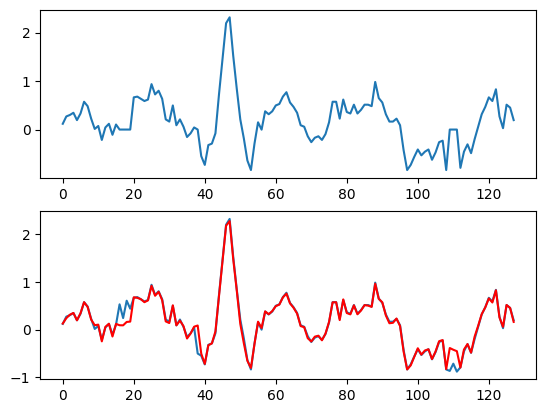

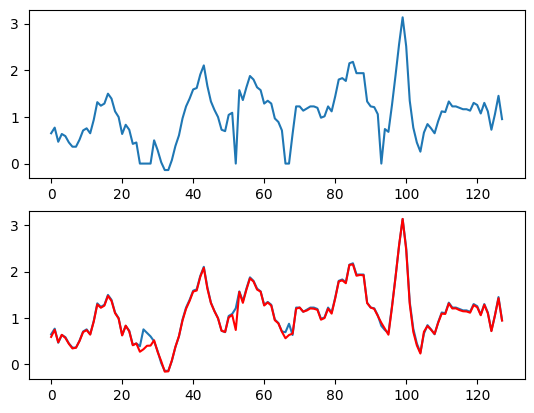

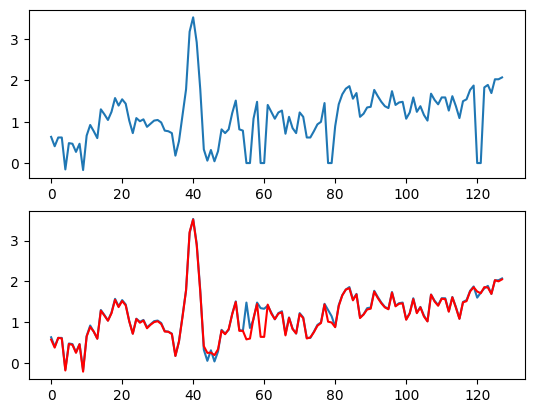

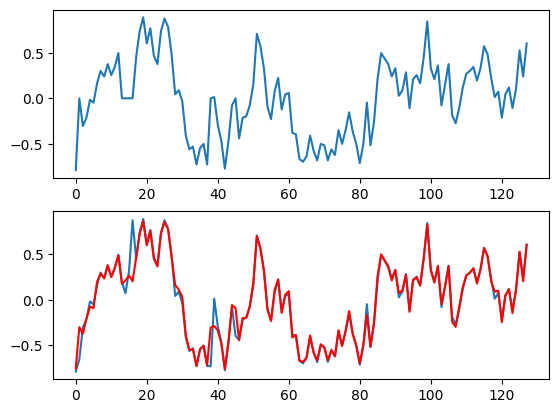

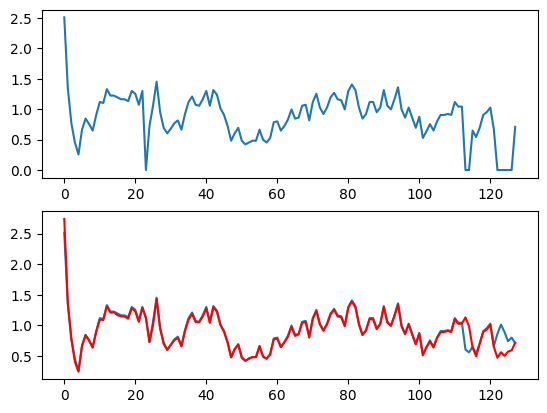

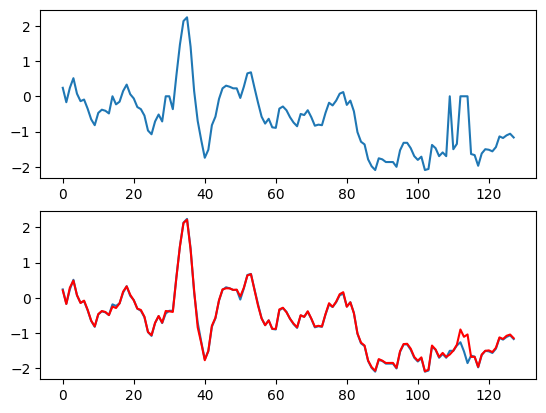

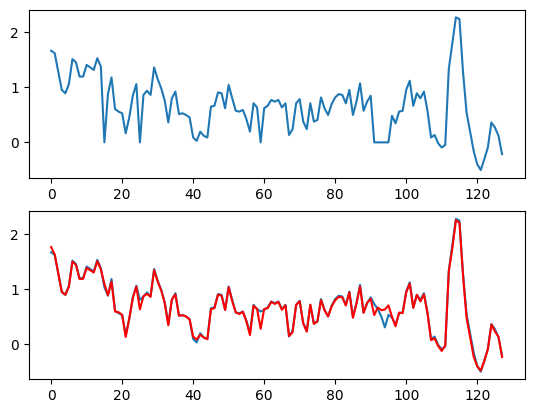

In [182]:
for i in range(N_SEG):
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(example_input[i])
    axs[1].plot(example_target[i])

    axs[1].plot(outputs[i].detach().cpu().numpy(), color="red")